# Supercompressible: regression 3d (energy absorbed)

This notebook intends to show the application of Gaussian processes to make predictions about the energy absorbed in the supercompressible example. In particular, the 3d circular case will be considered.

So, let's start by importing the required libraries:

In [1]:
# standard library
import pickle

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.gaussian_process.kernels import Matern

In [2]:
# %matplotlib qt

Now, let's import the data.

In [3]:
# get pandas frame
filename = 'DoE_results.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)

# define number of points to start with
N = 1000

points = data['points'].loc[:(N-1)]
print('variables:', [col for col in points.columns])

# get number of inputs
n_inputs = len(points.columns) - 3

# get X data
X = points.iloc[:,range(n_inputs)].values

# get y data
var_name = 'energy'
y = points.loc[:, var_name].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

variables: ['ratio_d', 'ratio_pitch', 'ratio_top_diameter', 'coilable', 'sigma_crit', 'energy']
X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06659863 1.07397461 0.26484375]
 [0.04934863 0.76147461 0.46484375]
 [0.01484863 1.38647461 0.06484375]]
X shape: (1000, 3)
y: [2.79529996e-04            nan 1.42853201e+01            nan
            nan            nan            nan            nan
            nan            nan 3.99711660e+01 1.98642673e+00
 6.48854850e-01            nan 4.20875110e+00            nan
 2.24569186e-02            nan 2.10498101e+01            nan
 4.55403500e+00            nan            nan            nan
 8.38232447e-02 7.41623887e+00 5.31569140e+01            nan
 4.09757310e-01            nan 4.13933948e+00            nan
            nan            nan 3.14033409e+01            nan
 1.53631118e+00 4.18742126e+01 9.97156896e+00            nan
 2.33465728e-01 2.24700133e+01 3.33725150e+01  

The variables ```X``` and ```y``` contain all the data. Nevertheless, there's ```NaN``` values that cannot be considered.

In [4]:
# missing indices
indices = pd.notnull(points.loc[:, var_name]).values

# get y data
y = points.loc[indices, var_name].values

# get X data
X = points.iloc[indices,range(n_inputs)].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

X: [[0.004      0.25       0.        ]
 [0.05575    0.5625     0.2       ]
 [0.0686875  0.328125   0.55      ]
 ...
 [0.05797363 0.29272461 0.16484375]
 [0.03209863 0.44897461 0.66484375]
 [0.06659863 1.07397461 0.26484375]]
X shape: (524, 3)
y: [2.79529996e-04 1.42853201e+01 3.99711660e+01 1.98642673e+00
 6.48854850e-01 4.20875110e+00 2.24569186e-02 2.10498101e+01
 4.55403500e+00 8.38232447e-02 7.41623887e+00 5.31569140e+01
 4.09757310e-01 4.13933948e+00 3.14033409e+01 1.53631118e+00
 4.18742126e+01 9.97156896e+00 2.33465728e-01 2.24700133e+01
 3.33725150e+01 9.52823054e+00 2.77888334e+00 1.01345895e+01
 3.19718168e+01 4.43715321e-01 1.36625561e+01 7.41887260e+00
 2.84245945e-03 1.95283561e+01 1.32108890e+00 8.15073575e+00
 1.53984456e-01 1.61164451e+01 1.07356998e+00 1.71328042e+01
 8.36574180e+00 1.45607740e-02 4.34244606e-02 6.57102433e+00
 2.61322467e+00 1.42408212e+01 1.17160871e-01 2.57801494e+01
 2.70598953e+00 2.26941338e+01 8.00264514e+00 3.20455203e-03
 1.63015018e+01 2.9624

Before starting to make predictions, Let's create a function to split the data and evaluate the results.

In [5]:
def split_data(X, y, train_size):
    
    # split data
    test_size = 1 - train_size
    indices = range(len(y))
    X_train = X[indices[:-int(round(len(indices) * test_size))]]
    X_test = X[indices[-int(round(len(indices) * test_size)):]]
    y_train = y[indices[:-int(round(len(indices) * test_size))]]
    y_test = y[indices[-int(round(len(indices) * test_size)):]]
    
    return (X_train, X_test, y_train, y_test)

In [6]:
def evaluate_model(model, X_test, y_mean_test, n_train):
    
    # predict test
    y_mean_pred = model.predict(X_test, return_std=False)

    # error metrics
    mse = mean_squared_error(y_mean_test, y_mean_pred)
    r2 = r2_score(y_mean_test, y_mean_pred)
    expl_var = explained_variance_score(y_mean_test, y_mean_pred)
    print("The mean squared error is %0.3e" % mse)
    print("The R2 score is %0.3f" % r2)
    print("The explained variance score is %0.3f" % expl_var)

    # plot predicted vs observed
    plt.figure()
    plt.plot(y_mean_test, y_mean_pred, 'o')
    plt.plot([np.min(y_mean_test), np.max(y_mean_test)], [np.min(y_mean_test), np.max(y_mean_test)], 'r-')
    plt.title('Posterior kernel: %s\n$n_{train} = %i$, $R^{2} = %0.3f$, $ MSE = %0.3e$' % (model.kernel_, n_train, r2, mse))
    plt.ylabel("Predicted")
    plt.xlabel("Observed")
    plt.show()

So, let's split the data and start to make some predictions!

The mean squared error is 8.936e+01
The R2 score is 0.439
The explained variance score is 0.441


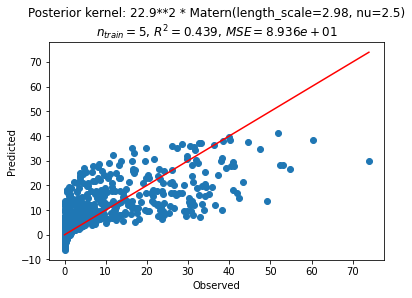

In [7]:
# choose train size
train_size = .01
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
kernel = 1.0 * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-1, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1**2, n_restarts_optimizer=0).fit(X_train_scaled, y_train)

# evaluate model
evaluate_model(model, X_test_scaled, y_test, n_train)

The results are terrible! Nevertheless, the picture is quite illustrative... some outliers are "killing" the regression. Let's plot an histogram of the outputs.

Text(0, 0.5, 'Frequency')

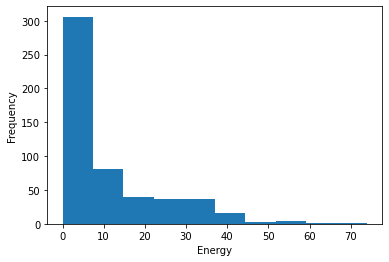

In [8]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')

The above histogram shows that almost all the simulations have output in (0, 500), but there's also outputs that are much larger. This can be justified by errors in the creation of the database: the algorithm to compute the energies used curves that should not have been considered. Therefore, the wisest strategy is to dismiss these points.

In [9]:
def perform_cleaning(X, y, n_std_cleaning):
    
    # compute threshold
    y_mean, y_std = np.mean(y), np.std(y)
    y_thresh = y_mean + n_std_cleaning * y_std

    # indices
    print(y_thresh)
    indices = np.where(y < y_thresh)
    n_dismissed_points = len(y) - len(indices[0])
    print('Dismissed points:', n_dismissed_points)

    # X and y
    y = y[indices]
    X = X[indices]
    print(np.shape(y))
    print(np.shape(X))

    return X, y, n_dismissed_points

In [10]:
n_std_cleaning = 5  # dismiss points that fall outside this range

n_dismissed_points = 1
n_max_iter = 2
n_iter = 0
while n_dismissed_points > 0 and n_iter < n_max_iter:
    X, y, n_dismissed_points = perform_cleaning(X, y, n_std_cleaning)
    n_iter += 1

73.4496060195835
Dismissed points: 1
(523,)
(523, 3)
71.83383738897406
Dismissed points: 0
(523,)
(523, 3)


Text(0, 0.5, 'Frequency')

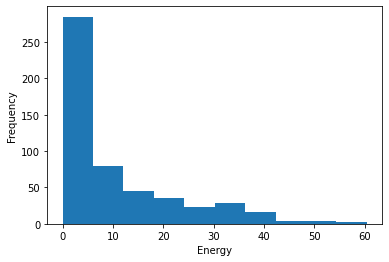

In [11]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')

And as expected, the predictions start to make sense. It is interesting (altought expected) to notice that the results are, for the same number of data points, much worse than the 3d case.

The mean squared error is 8.582e+01
The R2 score is 0.434
The explained variance score is 0.437


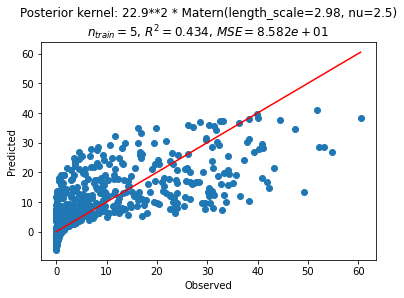

In [12]:
# choose train size
train_size = .01
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
kernel = 1.0 * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-1, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1**2, n_restarts_optimizer=0).fit(X_train_scaled, y_train)

# evaluate model
evaluate_model(model, X_test_scaled, y_test, n_train)

It seems that we are in the right track! Let's see how the data set size influences the results. In this case, we have to try out different methods, because Gaussian processes scale very poorly.

The mean squared error is 8.582e+01
The R2 score is 0.434
The explained variance score is 0.437


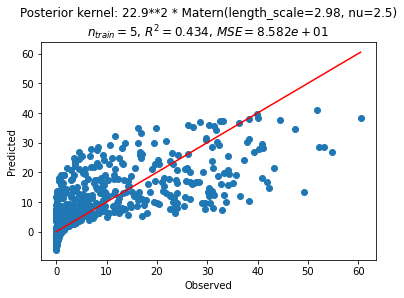

The mean squared error is 6.291e+01
The R2 score is 0.587
The explained variance score is 0.625


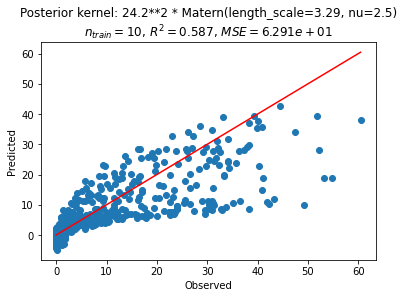

The mean squared error is 5.073e+00
The R2 score is 0.966
The explained variance score is 0.968


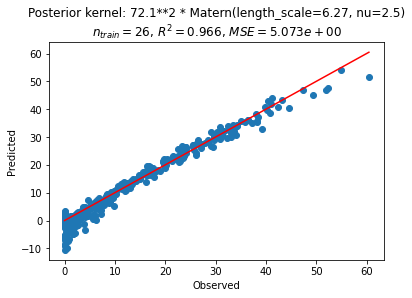

The mean squared error is 8.934e-01
The R2 score is 0.994
The explained variance score is 0.994


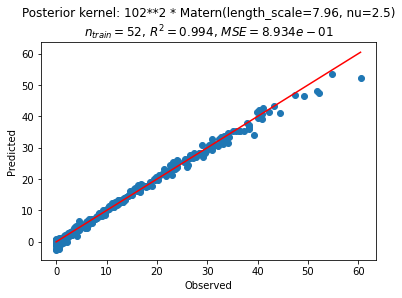

The mean squared error is 4.115e-01
The R2 score is 0.997
The explained variance score is 0.997


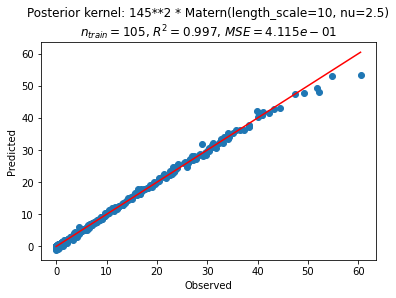

The mean squared error is 2.381e-01
The R2 score is 0.998
The explained variance score is 0.998


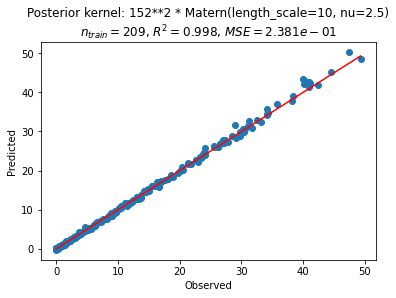

The mean squared error is 1.955e-01
The R2 score is 0.999
The explained variance score is 0.999


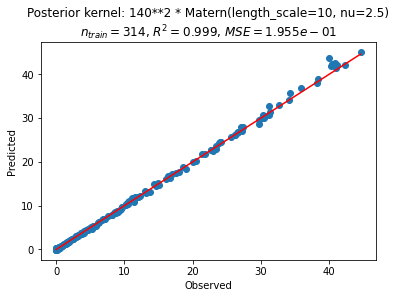

The mean squared error is 2.148e-01
The R2 score is 0.998
The explained variance score is 0.999


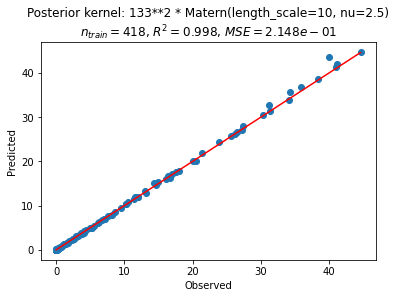

In [13]:
# choose train size
train_size = [.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

# train and predict
scalers = []
models = []
for train_size_ in train_size:
    # choose train size
    (X_train, X_test, y_train, y_test) = split_data(X, y, train_size_)
    n_train = len(X_train)

    # scale data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # train and predict
    kernel = 1.0 * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-1, 10.0))
    model = GaussianProcessRegressor(kernel=kernel, alpha=1**2, n_restarts_optimizer=0).fit(X_train_scaled, y_train)

    # evaluate model
    evaluate_model(model, X_test_scaled, y_test, n_train)
    
    # store models
    scalers.append(scaler)
    models.append(model)

Let's define function to plot the outputs.

In [14]:
def make_reg_plot(scaler, reg, variables, x3, labels, bounds):

    column_names = [col for col in points.columns]

    indices =  [column_names.index(name) for name in variables]

    xx = np.meshgrid(np.arange(bounds[0][0], bounds[0][1], 0.02),
                          np.arange(bounds[1][0], bounds[1][1], 0.02))

    n = len(xx[0].ravel())
    xx.append(x3 * np.ones(n))

    XX = np.empty((n, 3))
    for index, xx_ in zip(indices, xx):
        XX[:, index] = xx_.ravel()

    XX_scaled = scaler.transform(XX)

    Y = reg.predict(XX_scaled)
    Y = Y.reshape(xx[0].shape)

    # plot
    fig, ax = plt.subplots()
    cs = ax.contourf(xx[0], xx[1], Y, alpha=0.8, cmap=plt.get_cmap('jet'))
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title('%s = %.2g' % (labels[2], x3))
    fig.colorbar(cs)

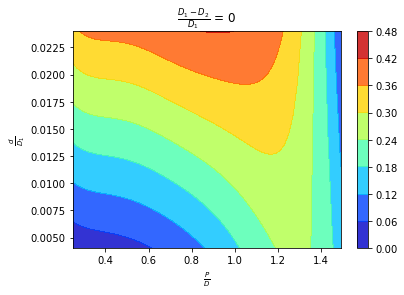

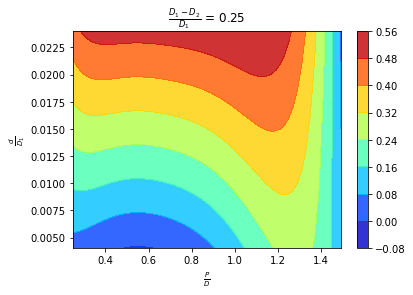

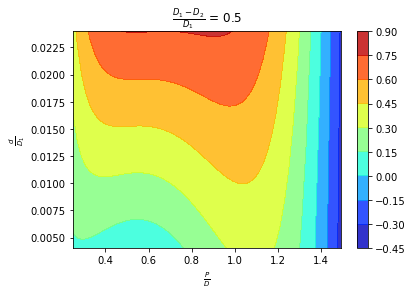

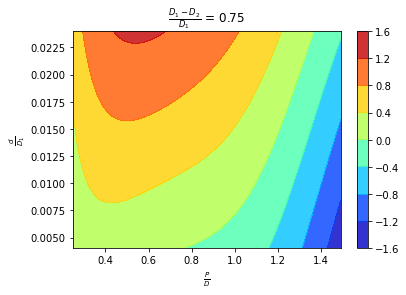

In [15]:
variables = ['ratio_pitch', 'ratio_d', 'ratio_top_diameter']
labels = ['$\\frac{P}{D}$', '$\\frac{d}{D_1}$', '$\\frac{D_1 - D_2}{D_1}$']
bounds = [data['doe_variables'][name] for name in variables]
bounds[1] = [0.004, 0.025]

scaler = scalers[-1]
reg = models[-1]

for x3 in [0., 0.25, 0.5, 0.75]:
    make_reg_plot(scaler, reg, variables, x3, labels, bounds)

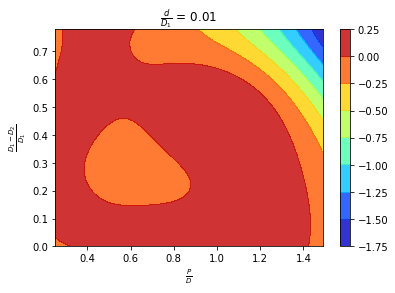

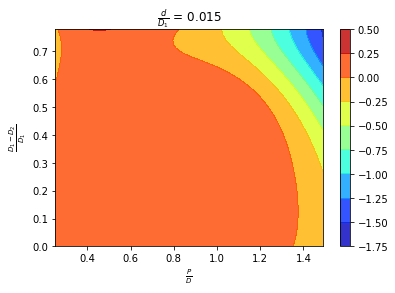

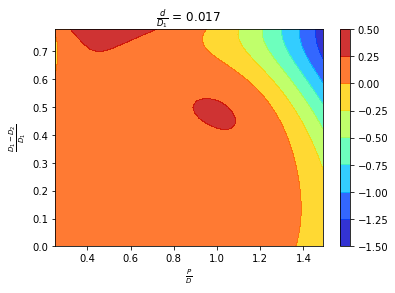

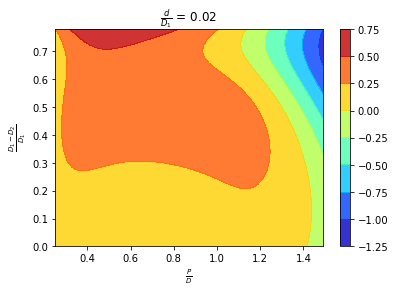

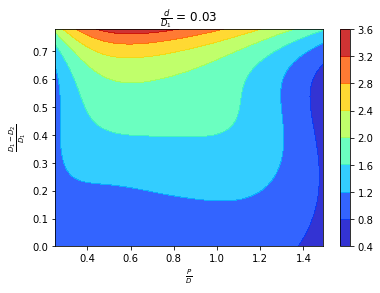

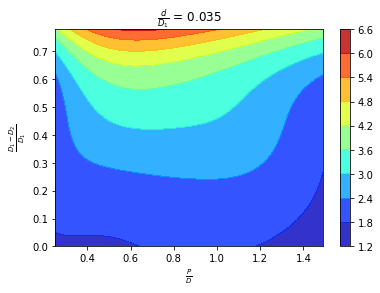

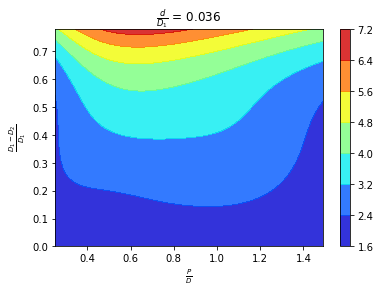

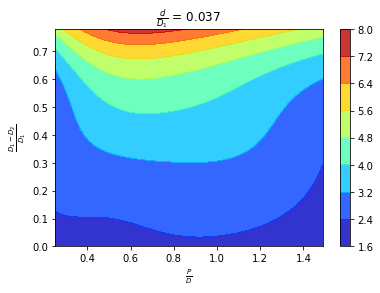

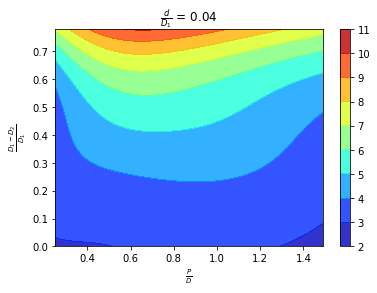

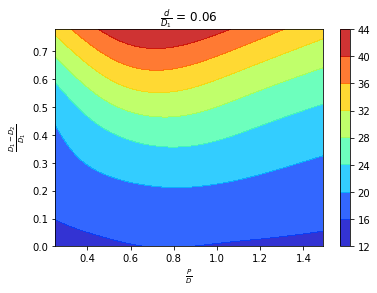

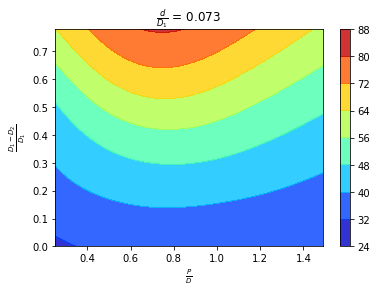

In [16]:
plot_variables = ['ratio_pitch', 'ratio_top_diameter', 'ratio_d']
plot_labels = ['$\\frac{P}{D}$', '$\\frac{D_1 - D_2}{D_1}$', '$\\frac{d}{D_1}$']
plot_bounds = [data['doe_variables'][name] for name in plot_variables]

for x3 in [0.01, 0.015, 0.017, 0.02, 0.03, 0.035, 0.036, 0.037, 0.04, 0.06, 0.073]:
    make_reg_plot(scaler, reg, plot_variables, x3, plot_labels, plot_bounds)

Let's make predictions for given points.

In [17]:
xx = [[0.04276196, 0.41448975, 0.69628906], # best in full dataset
      [0.03954443, 0.51306152, 0.65351563],  # best in full dataset (N=3000)
      [0.0337832, 0.32080078, 0.7578125],  # best in full dataset (N=1000)
      [0.03710181, 0.26312256, 0.77441406], # best in the dataset after classification with N=10000
      [0.02876318, 0.31774902, 0.72851562], # best in the dataset after classification with N=5000
      [0.0337832,  0.32080078, 0.7578125], # best in the dataset after classification with N=3000 and N=1000
      [0.04, 0.417, 0.8], # best found after after classification and regression with N=10000
      [0.038, 0.32, 0.8], # best found after after classification and regression with N=5000
      [0.037, 0.32, 0.8], # best found after after classification and regression with N=3000
      [0.037, 0.47, 0.8], # best found after after classification and regression with N=1000
      [0.037, 0.4, 0.8],
      ]
yy = reg.predict(scaler.transform(xx))

print(yy)

[9.45993762 6.78891961 3.86931539 5.28746372 1.76469643 3.86931539
 9.66808431 7.09768642 6.41923744 7.60459791 7.15408587]
